# Merging 6-beam scans

### Introduction:

The work from [Sathe et al. 2015](https://doi.org/10.5194/amt-8-729-2015) introduces an alternative scanning strategy to be used by wind Doppler lidars for estimating turbulence (6-beam). This new strategy consists of measuring the radial wind on five equally spaced azimuths with fixed elevation, different from 0 or 90 degrees,  and one additional measurement from the zenith.

This example shows how to use the lidarwind to retrieve wind speed and direction profiles from the 6-beam observations. The profiles are retrieved using the FFT, following the method proposed by [Ishwardat 2017](http://resolver.tudelft.nl/uuid:a659654b-e76a-4513-a656-ecad761bdbc8).

### Steps:

0) Download data from zenodo
1) Read the WindCube's data
2) Merge data from one hour of observations
3) Re-structure the data for using the wind retrieval
4) Retrieve wind speed and directin profiles
5) Visualisation

In [1]:
import pooch
import matplotlib.pyplot as plt
import lidarwind as lst

### Step 0: Downloading the sample data

Using pooch the sample dataset will be cached in your system.

In [2]:
file_list = pooch.retrieve( 
    url="doi:10.5281/zenodo.7312960/wc_6beam.zip",
    known_hash="md5:a7ea3c10a6d2f4a97ff955dc4398f930",
    processor=pooch.Unzip())

### Step 1 and 2: reading and merging the 6-beam data

In [3]:
file_list = sorted(file_list)
merged_ds = lst.DataOperations(file_list).merged_data

/Users/jdiasneto/Projects/LST_package_name/lidarwind/data_operator.py:147: UserWarning: rename 'range' to 'range90' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.tmp90 = self.tmp90.rename({var: f"{var}90"})


Below you can see all the variables available on the original WindCube's data. Not all of them are needed for retrieving the wind profiles. Note that the variables from the vertical observations are kept separate from the slanted observation. 

In [4]:
merged_ds

<xarray.Dataset>
Dimensions:                                  (time: 715, range90: 143,
                                              range: 137)
Coordinates:
  * time                                     (time) datetime64[ns] 2021-05-13...
  * range90                                  (range90) int32 100 150 ... 7200
  * range                                    (range) int32 104 156 ... 7124 7176
Data variables: (12/34)
    scan_file                                (time) object b'(\xe1\x18\xd5\xf...
    settings_file                            (time) object b'E\xc7_t<\xb7\x10...
    res_file                                 (time) object b'7\x1bb\x06\x0f\x...
    ray_angle_resolution                     (time) float64 0.0 0.0 ... 0.0 0.0
    range_gate_length                        (time) float64 50.0 50.0 ... 50.0
    ray_accumulation_time                    (time) float64 2e+03 ... 2e+03
    ...                                       ...
    radial_wind_speed                        (time, range) float64 1.8 ... -3...
    radial_wind_speed_ci                     (time, range) float64 100.0 ... 0.0
    radial_wind_speed_status                 (time, range) float32 1.0 ... 0.0
    doppler_spectrum_width                   (time, range) float64 0.91 ... 2.92
    doppler_spectrum_mean_error              (time, range) float64 2.6 ... 55.7
    relative_beta                            (time, range) float64 1.01e-07 ....

First inpressions from the slanted and vertical observations

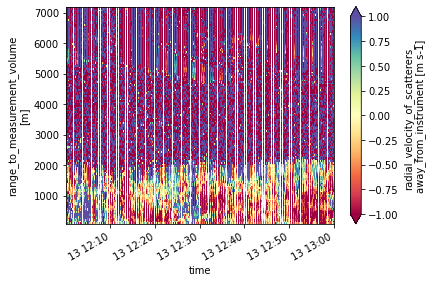

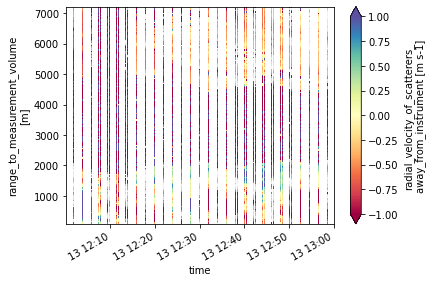

In [5]:
merged_ds.radial_wind_speed.plot(x='time', cmap='Spectral',vmin=-1, vmax=1)
plt.show()

merged_ds.radial_wind_speed90.plot(x='time', cmap='Spectral', vmin=-1, vmax=1)
plt.show()

### Step 3: re-structuring the data

In [6]:
restruct_data = lst.GetRestructuredData(merged_ds)

The re-structured object contains all the information needed to retrieve the wind profiles. You can have a look again at the slanted and vertical observations.

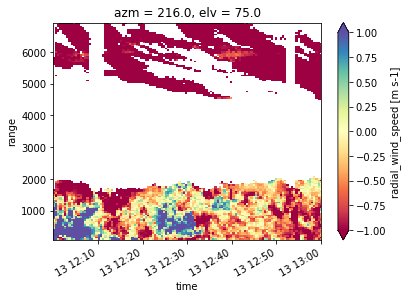

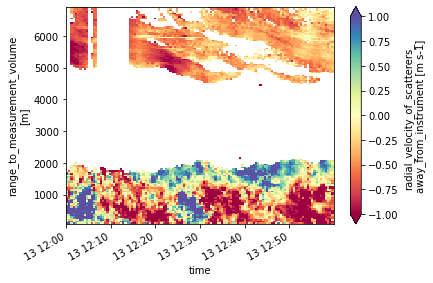

In [7]:
# Radial observation at an elevation of 75 degrees and an azimuth of 216 degrees
restruct_data.data_transf.isel(azm=3).plot(x='time',cmap='Spectral',vmin=-1, vmax=1)
plt.show()

# Observations from the zenith pointing measurements
restruct_data.data_transf_90.plot(x='time', cmap='Spectral', vmin=-1, vmax=1)
plt.show()

### Step 4: retrieving wind profiles

Wind speed and direction profiles are retrieved using the FFT method at this step. 

In [8]:
wind_obj = lst.RetriveWindFFT(restruct_data)

/opt/miniconda3/envs/lidarSuit/lib/python3.8/site-packages/xrft/xrft.py:338: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


After retrieving the wind profiles, the dataset can be accessed by calling the wind_prop attribute. You can also visualize the retrieved wind speed and direction profiles. Have a look below.

In [9]:
wind_obj.wind_prop

<xarray.Dataset>
Dimensions:                    (time: 596, range: 137, time90: 119)
Coordinates:
  * time                       (time) datetime64[ns] 2021-05-13T12:00:03.7190...
  * range                      (range) int32 100 150 200 250 ... 6800 6850 6900
  * time90                     (time90) datetime64[ns] 2021-05-13T12:00:14.74...
Data variables:
    horizontal_wind_direction  (time, range) float64 30.74 25.43 ... nan nan
    horizontal_wind_speed      (time, range) float64 2.629 5.361 ... nan nan
    zonal_wind                 (time, range) float64 -1.344 -2.302 ... nan nan
    meridional_wind            (time, range) float64 -2.259 -4.841 ... nan nan
    vertical_wind_speed        (time90, range) float64 1.05 0.21 ... nan nan
    lidar_relative_beta        (time90, range) float64 1.48e-07 1.54e-07 ... nan
Attributes:
    Conventions:      Cf/Radial 2.0
    title:            Wind properties
    references:       Generated by lidarwind version: temporary config file
    institution:      institution name
    instrument_name:  instrument name
    comments:         General comments
    site_name:        site name
    contact_person:   contact person
    email:            contact email

### Step 5: Visualisation

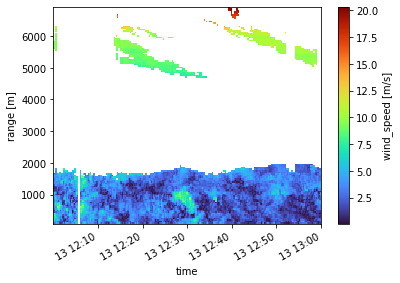

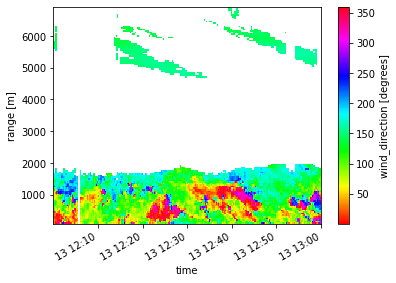

In [10]:
wind_obj.wind_prop.horizontal_wind_speed.plot(y='range', cmap='turbo')
plt.show()

wind_obj.wind_prop.horizontal_wind_direction.plot(y='range', cmap='hsv')
plt.show()

In [11]:
# Uncomment the line below save it as NetCDF
# wind_obj.wind_prop.to_netcdf('6_beam_example.nc')